In [1]:
# !pip install sentencepiece --quiet
# !pip install sacrebleu --quiet
# !pip install torchdata --quiet

# !pip install --upgrade lxml
## make restart to kernel

In [2]:
# !pip install torchtext
# !pip install einops
# !pip install fastcore
# !pip install fastprogress
# !pip install torcheval

In [3]:
import math
from copy import copy
from dataclasses import dataclass
from contextlib import contextmanager
from functools import partial
from collections.abc import Mapping

import numpy as np
import sacrebleu
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchtext.datasets import Multi30k
from tqdm import tqdm
from operator import attrgetter,itemgetter
import fastcore.all as fc
from fastprogress import progress_bar,master_bar
from torcheval.metrics import Mean

from rotary_embedding.rotary_embedding_torch import RotaryEmbedding

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
import pdb

## Data treparation for tokenizer training

In [5]:
SRC = "de"
TRG = "en"

In [6]:
train_iter = Multi30k(split='train', language_pair=(SRC, TRG))
f_de = open("Multi30k_de_text.txt", "w")
f_en = open("Multi30k_en_text.txt", "w")
for pair in train_iter:
    f_de.write(pair[0]+'\n')
    f_en.write(pair[1]+'\n')
f_de.close()
f_en.close()

In [7]:
en_vocab_size = 8200
de_vocab_size = 10000
vocab_sizes = {"en": en_vocab_size, "de": de_vocab_size}

## train sentencepice models for tokenizers

In [8]:
txt_file1='Multi30k_en_text.txt'
txt_file2='Multi30k_de_text.txt'
model1_prefix='Multi30k_en'
model2_prefix='Multi30k_de'
vocab1_size=8200
vocab2_size=10000
spm.SentencePieceTrainer.train(f'--input={txt_file1} --model_prefix={model1_prefix} --user_defined_symbols=<pad> --vocab_size={vocab1_size}')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=Multi30k_en_text.txt --model_prefix=Multi30k_en --user_defined_symbols=<pad> --vocab_size=8200
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: Multi30k_en_text.txt
  input_format: 
  model_prefix: Multi30k_en
  model_type: UNIGRAM
  vocab_size: 8200
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  p

In [9]:
class Tokenizers:
    def __init__(self, sp1, sp2, vocab1_size, vocab2_size, lang1, lang2, model1_prefix, model2_prefix):
        fc.store_attr()
        self.tokenizers = {lang1: self.sp1.encode_as_ids, self.lang2: self.sp2.encode_as_ids}
        self.detokenizers = {self.lang1: self.sp1.decode_ids, self.lang2: self.sp2.decode_ids}
        
    @classmethod
    def from_files(cls, txt_file1='Multi30k_en_text.txt', txt_file2='Multi30k_de_text.txt', model1_prefix='Multi30k_en',
                   model2_prefix='Multi30k_de', vocab1_size=8200, vocab2_size=10000, lang1="en", lang2="de"):
        spm.SentencePieceTrainer.train(f'--input={txt_file2} --model_prefix={model2_prefix} --user_defined_symbols=<pad> --vocab_size={vocab2_size}')
        spm.SentencePieceTrainer.train(f'--input={txt_file1} --model_prefix={model1_prefix} --user_defined_symbols=<pad> --vocab_size={vocab1_size}')

        # make SentencePieceProcessor instances and load the model files
        sp2 = spm.SentencePieceProcessor()
        sp2.load(f'{model2_prefix}.model')
        sp1 = spm.SentencePieceProcessor()
        sp1.load(f'{model1_prefix}.model')
        
        return cls(sp1=sp1, sp2=sp2, vocab1_size=8200, vocab2_size=10000, lang1=lang1, lang2=lang2, model1_prefix=model1_prefix, model2_prefix=model2_prefix)

#         tokenizers = {"en": en_sp.encode_as_ids, "de": de_sp.encode_as_ids}
#         detokenizers = {"en":en_sp.decode_ids, "de":de_sp.decode_ids}
#         return tokenizers, detokenizers

# def get_tokenizers(vocab_sizes={"en": 8200, "de": 10000}):
#     spm.SentencePieceTrainer.train\
#     (f'--input=Multi30k_de_text.txt --model_prefix=Multi30k_de --user_defined_symbols=<pad> --vocab_size={de_vocab_size}')
#     spm.SentencePieceTrainer.train\
#     (f'--input=Multi30k_en_text.txt --model_prefix=Multi30k_en --user_defined_symbols=<pad> --vocab_size={en_vocab_size}')

#     # make SentencePieceProcessor instances and load the model files
#     de_sp = spm.SentencePieceProcessor()
#     de_sp.load('Multi30k_de.model')
#     en_sp = spm.SentencePieceProcessor()
#     en_sp.load('Multi30k_en.model')

#     tokenizers = {"en": en_sp.encode_as_ids, "de": de_sp.encode_as_ids}
#     detokenizers = {"en":en_sp.decode_ids, "de":de_sp.decode_ids}
#     return tokenizers, detokenizers

# tokenizers, detokenizers=get_tokenizers()

tokenizers=Tokenizers.from_files()

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=Multi30k_de_text.txt --model_prefix=Multi30k_de --user_defined_symbols=<pad> --vocab_size=10000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: Multi30k_de_text.txt
  input_format: 
  model_prefix: Multi30k_de
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
 

In [11]:
# # train sentencepiece models to get tokenizers
# spm.SentencePieceTrainer.train\
# (f'--input=Multi30k_de_text.txt --model_prefix=Multi30k_de --user_defined_symbols=<pad> --vocab_size={de_vocab_size}')
# spm.SentencePieceTrainer.train\
# (f'--input=Multi30k_en_text.txt --model_prefix=Multi30k_en --user_defined_symbols=<pad> --vocab_size={en_vocab_size}')

# # make SentencePieceProcessor instances and load the model files
# de_sp = spm.SentencePieceProcessor()
# de_sp.load('Multi30k_de.model')
# en_sp = spm.SentencePieceProcessor()
# en_sp.load('Multi30k_en.model')

# tokenizers = {"en": en_sp.encode_as_ids, "de": de_sp.encode_as_ids}
# detokenizers = {"en":en_sp.decode_ids, "de":de_sp.decode_ids}

# encode: text => id
# print(tokenizers["en"]sp.encode_as_pieces('This is a test'))
# print(en_sp.encode_as_ids('This is a test'))

# # decode: id => text
# print(en_sp.decode_pieces(['▁This', '▁is', '▁a', '▁t', 'est']))
# print(en_sp.decode_ids([302, 258, 10, 4, 2395]))

In [12]:
print(tokenizers.tokenizers["en"]('This is a test'))
print(tokenizers.sp1.encode_as_ids('This is a test'))

[302, 258, 10, 4, 2395]
[302, 258, 10, 4, 2395]


In [13]:
print(tokenizers.sp1.decode_pieces(['▁This', '▁is', '▁a', '▁t', 'est']))
print(tokenizers.sp1.decode_ids([302, 258, 10, 4, 2395]))

▁This is a test
This is a test


In [14]:
print([tokenizers.sp1.id_to_piece(id) for id in range(20)])
print([tokenizers.sp2.id_to_piece(id) for id in range(20)])

['<unk>', '<s>', '</s>', '<pad>', '▁a', '.', '▁A', '▁in', '▁the', '▁on', '▁is', '▁man', '▁and', '▁of', '▁with', 's', 'ing', '▁', ',', '▁woman']
['<unk>', '<s>', '</s>', '<pad>', '.', '▁eine', '▁Ein', 'm', '▁in', '▁mit', ',', '▁und', '▁auf', '▁ein', '▁Mann', '▁einer', '▁Eine', 'n', '▁der', '▁Frau']


In [15]:
#indexes of special symbols
# UNK, BOS, EOS, PAD = 0, 1, 2, 3

## Preporcess data

In [16]:
# train_iter = Multi30k(split='train', language_pair=(SRC, TRG))
# valid_iter = Multi30k(split='valid', language_pair=(SRC, TRG))
# test_iter  = Multi30k(split='test',  language_pair=(SRC, TRG))

# train_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in train_iter if x!='']
# valid_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in valid_iter if x!='']
# test_set  = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in test_iter if x!='']
# print(len(train_set), len(valid_set), len(test_set))
# for i in range(10):
#     print(train_set[i])

### tokenize

In [17]:
max_seq_len = 50
def tokenize_dataset(dataset, src, trg, bos_id, eos_id, tokenizers, max_seq_len=50):
    'tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences'
    return [(torch.tensor([bos_id]+tokenizers.tokenizers[src](src_text)[0:max_seq_len-2]+[eos_id]),
             torch.tensor([bos_id]+tokenizers.tokenizers[trg](trg_text)[0:max_seq_len-2]+[eos_id]))
            for src_text, trg_text in dataset]
          
# train_tokenized = tokenize_dataset(train_set)
# valid_tokenized = tokenize_dataset(valid_set)
# test_tokenized  = tokenize_dataset(test_set)

### datasets

In [18]:
class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch, pad_id):
    'collate function for padding sentences such that all \
    the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = pad_id)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = pad_id)
    return src_padded, trg_padded

In [19]:
batch_size = 128

In [20]:
class DataLoaders:
    def __init__(self, unk_id, bos_id, eos_id, pad_id, batch_size, max_seq_len, *dls): 
        self.train, self.valid, self.test = dls[:3]
        self.unk_id, self.bos_id, self.eos_id, self.pad_id=unk_id, bos_id, eos_id, pad_id
        self.batch_size, self.max_seq_len = batch_size, max_seq_len

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        # return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds), **kwargs) for ds in dd.values()])
        return cls(*[torch.utils.data.DataLoader(TranslationDataset(ds), batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence,  **kwargs) for ds in dd])
    
    @classmethod
    def from_iters(cls, train_iter, valid_iter, test_iter, src, trg, tokenizers, batch_size=128, max_seq_len=50, as_tuple=True, 
                   unk_id=0, bos_id=1, eos_id=2, pad_id=3, **kwargs):
        train_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in train_iter if x!='']
        valid_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in valid_iter if x!='']
        test_set  = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in test_iter if x!='']
        
        train_tokenized = tokenize_dataset(train_set, src, trg, bos_id, eos_id, tokenizers, max_seq_len)
        valid_tokenized = tokenize_dataset(valid_set, src, trg, bos_id, eos_id, tokenizers, max_seq_len)
        test_tokenized  = tokenize_dataset(test_set, src, trg, bos_id, eos_id, tokenizers, max_seq_len)
        pad_sequence_partial=partial(pad_sequence, pad_id=pad_id)
        return cls(unk_id, bos_id, eos_id, pad_id, batch_size, max_seq_len, 
                   *[torch.utils.data.DataLoader(TranslationDataset(ds), batch_size=batch_size,
                                                 shuffle=True, collate_fn = pad_sequence_partial,  **kwargs) \
                     for ds in (train_tokenized, valid_tokenized, test_tokenized)])
        
def get_dls(src, trg, tokenizers, batch_size=128, max_seq_len=50):
    train_iter = Multi30k(split='train', language_pair=(src, trg))
    valid_iter = Multi30k(split='valid', language_pair=(src, trg))
    test_iter  = Multi30k(split='test',  language_pair=(src, trg))
    dls=DataLoaders.from_iters(train_iter, valid_iter, test_iter, src, trg, tokenizers, batch_size, max_seq_len)
    return dls

In [21]:
dls=get_dls(SRC, TRG, tokenizers)

In [22]:
# next(iter(dls.train))

## Model

In [23]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0, use_rot_emb=True):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)
        self.use_rot_emb=use_rot_emb
        if use_rot_emb:
            self.rotary_emb = RotaryEmbedding(dim = self.d_k//2)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        if self.use_rot_emb:
            query = self.rotary_emb.rotate_queries_or_keys(query)
            key = self.rotary_emb.rotate_queries_or_keys(key)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
    '''residual connection: x + dropout(sublayer(layernorm(x))) '''
    def __init__(self, dim, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, sublayer):
        return x + self.drop(sublayer(self.norm(x)))

# I simply let the model learn the positional embeddings in this notebook, since this 
# almost produces identital results as using sin/cosin functions embeddings, as claimed
# in the original transformer paper. Note also that in the original paper, they multiplied 
# the token embeddings by a factor of sqrt(d_embed), which I do not do here. 

class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)


class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout, config.use_rot_emb)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
    
    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed, use_rot_emb=config.use_rot_emb)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed, use_rot_emb=config.use_rot_emb)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)

In [24]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    use_rot_emb: bool
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float
    pad_id: int
    unk_id: int
    bos_id: int
    eos_id: int

def make_model(config, device='cuda'):
    model = Transformer(Encoder(config), Decoder(config)).to(device)
    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    model.pad_id=config.pad_id
    model.unk_id=config.unk_id
    model.bos_id=config.bos_id
    model.eos_id=config.eos_id
    return model

## Callbacks

In [25]:
class CancelFitException(Exception): 
    pass
class CancelBatchException(Exception): 
    pass
class CancelEpochException(Exception): 
    pass

class Callback(): 
    order = 0
    
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: 
            # print(method)
            method(learn)

## Learner

In [26]:
def make_batch_input(batch, device, pad_id):
    x, y = batch[0], batch[1]
    src = x.to(device)
    trg_in = y[:, :-1].to(device)
    trg_out = y[:, 1:].contiguous().view(-1).to(device)
    src_pad_mask = (src == pad_id).view(src.size(0), 1, 1, src.size(-1))
    trg_pad_mask = (trg_in == pad_id).view(trg_in.size(0), 1, 1, trg_in.size(-1))
    return {'src':src, 'trg_in':trg_in, 'trg_out':trg_out, 'src_pad_mask':src_pad_mask, 'trg_pad_mask':trg_pad_mask}
    
    
class TrainCB(Callback):
    def __init__(self, grad_acc_steps=1):
        super(Callback, self).__init__()
        fc.store_attr()
        
    def predict(self, learn): 
        learn.batch = make_batch_input(learn.batch, learn.device, learn.model.pad_id)
        preds = learn.model(learn.batch['src'], learn.batch['src_pad_mask'], learn.batch['trg_in'], learn.batch['trg_pad_mask'])
        learn.preds = preds.view(-1, preds.size(-1))
        
    def get_loss(self, learn):
        learn.loss_func(learn)
        
    def backward(self, learn):
        learn.loss.backward()
            
    def step(self, learn): 
        learn.opt.step()
        
    def zero_grad(self, learn):
        learn.opt.zero_grad()

In [27]:
class Learner():
    def __init__(self, model, dls, loss_func=None, lr=0.1, cbs=None, device='cuda', opt_func=torch.optim.Adam):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def callback_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: 
            pass
        finally: 
            self.callback(f'cleanup_{nm}')

    def one_epoch(self, train):
        self.model.train(train)
        
        self.dl = self.dls.train if train else self.dls.valid
        # pdb.set_trace()
        with self.callback_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.callback_ctx('batch'):
                    self.predict()
                    self.callback('after_predict')
                    self.get_loss()
                    self.callback('after_loss')
                    if self.training:
                        self.backward()
                        self.callback('after_loss')
                        self.step()
                        self.callback('after_step')
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=False, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: 
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            # pdb.set_trace()
            with self.callback_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: 
                        self.one_epoch(True)
                    if valid: 
                        torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: 
                self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): 
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): 
        run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): 
        return self.model.training

## Progress cb

In [28]:
def to_cpu(x):
    if isinstance(x, Mapping): 
        return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): 
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple): 
        return tuple(to_cpu(list(x)))
    return x.detach().cpu()


class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: 
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        
    def _log(self, d): 
        print(d)
        
    def before_fit(self, learn): 
        learn.metrics = self
        
    def before_epoch(self, learn): 
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        batch = to_cpu(learn.batch)
        for m in self.metrics.values(): 
            m.update(to_device(batch), learn)
        self.loss.update(to_cpu(learn.loss), weight=len(batch))
        
        
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): 
        self.plot = plot
        
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): 
            learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): 
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
        
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

## Loss calc

In [29]:
class CustomLoss():
    def __init__(self, loss_fun):
        self.loss_fun=loss_fun()

    def calc_loss(self, learn): 
        trg_out=learn.batch['trg_out']
        loss=self.loss_fun(learn.preds, trg_out)
        learn.loss = loss

In [30]:
# loss_cl=CustomLoss(partial(nn.CrossEntropyLoss, ignore_index=PAD))

In [31]:
# PAD

In [32]:
# pr=partial(nn.CrossEntropyLoss, ignore_index=PAD)
# pr()

## Gradient clipping

In [33]:
class GradientClipping(Callback):
    order=2
    def __init__(self, grad_norm_clip=1.0):
        self.grad_norm_clip=grad_norm_clip
        
    def after_loss(self, learn):
        torch.nn.utils.clip_grad_norm_(learn.model.parameters(), self.grad_norm_clip)

## Scheduler

In [34]:
class BaseSchedCB(Callback):
    def __init__(self, sched): 
        self.sched = sched
        self.lrs=[]
        
    def before_fit(self, learn): 
        self.schedo = self.sched(learn.opt)
        
    def step_(self, learn):
        if learn.training: 
            self.schedo.step()
            self.lrs.append(self.schedo.get_last_lr()[0])
        
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn):
        self.step_(learn) 
        
        
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn):
        if learn.training: 
            self.step_(learn) 

## Set parameters and callbacks for training

In [35]:
#dataloaders
batch_size = 128
max_seq_len=50
dls=get_dls(SRC, TRG, tokenizers, batch_size, max_seq_len)

#model config
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC], 
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=512,
                     use_rot_emb=True,
                     d_ff=512, 
                     h=8,
                     N_encoder=3, 
                     N_decoder=3, 
                     max_seq_len=max_seq_len,
                     dropout=0.1,
                     pad_id=dls.pad_id,
                     unk_id=dls.unk_id,
                     bos_id=dls.bos_id,
                     eos_id=dls.eos_id)

model = make_model(config)

#optimizer
lr=0.5
optimizer_func = partial(torch.optim.Adam, betas=(0.9, 0.98), eps=1e-9)

#lr scheduler
warmup_steps = 3*len(dls.train)
# lr first increases in the warmup steps, and then decreases
lr_fn = lambda step: config.d_embed**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])  
lr_scheduler = partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda=lr_fn)
#loss
loss_cl=CustomLoss(partial(nn.CrossEntropyLoss, ignore_index=dls.pad_id))
loss_func=loss_cl.calc_loss

grad_norm_clip = 1.0

In [36]:
#init callbacks
cbs = [TrainCB(),
       BatchSchedCB(lr_scheduler), 
       GradientClipping(grad_norm_clip),
       MetricsCB(),
       ProgressCB(plot=True)]

In [37]:
learner = Learner(model, dls, loss_func, lr, cbs, opt_func=optimizer_func)

loss,epoch,train
5.512,0,train
3.560,0,eval
2.929,1,train
2.382,1,eval
2.056,2,train
1.951,2,eval


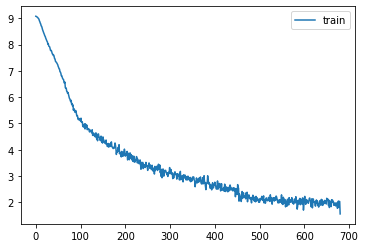

In [38]:
N_epochs=3
learner.fit(N_epochs, valid=True)

## Evaluate model scores

In [39]:
def translate(model, x, pad_id, device='cuda'):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[model.bos_id]*dB]).view(dB, 1).to(device)
        x_pad_mask = (x == model.pad_id).view(x.size(0), 1, 1, x.size(-1)).to(device)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == pad_id).view(y.size(0), 1, 1, y.size(-1)).to(device)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(device)
    return y

def remove_pad(sent, eos_id, pad_id):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(eos_id)>0:
        sent = sent[0:sent.index(eos_id)+1]
    while sent and sent[-1] == pad_id:
        sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids, eos_id, pad_id):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids, eos_id, pad_id)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, eos_id, pad_id, src_lang, trg_lang, detokenizers, num_batch=None, device='cuda'):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            batch = make_batch_input([x, y], device, pad_id)
            translation = translate(model, batch["src"], pad_id)
            batch["trg_out"] = batch["trg_out"].view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[trg_lang], batch['trg_out'][i], eos_id, pad_id) for i in range(len(batch["src"]))]
            cans = cans + [decode_sentence(detokenizers[trg_lang], translation[i], eos_id, pad_id) for i in range(len(batch["src"]))] 
            if num_batch and idx>=num_batch:
                break
        print(min([len(x) for x in refs]))
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[src_lang], batch["src"][i], eos_id, pad_id)}')
            print(f'trg:  {decode_sentence(detokenizers[trg_lang], batch["trg_out"][i], eos_id, pad_id)}')
            print(f'pred: {decode_sentence(detokenizers[trg_lang], translation[i], eos_id, pad_id)}')
        return np.mean(bleus)

In [40]:
# def make_batch_input(batch, device, pad_id):
#     x, y = batch[0], batch[1]
#     src = x.to(device)
#     trg_in = y[:, :-1].to(device)
#     trg_out = y[:, 1:].contiguous().view(-1).to(device)
#     src_pad_mask = (src == pad_id).view(src.size(0), 1, 1, src.size(-1))
#     trg_pad_mask = (trg_in == pad_id).view(trg_in.size(0), 1, 1, trg_in.size(-1))
#     return {'src':src, 'trg_in':trg_in, 'trg_out':trg_out, 'src_pad_mask':src_pad_mask, 'trg_pad_mask':trg_pad_mask}

In [41]:
# def make_batch_input(x, y):
#         src = x.to(DEVICE)
#         trg_in = y[:, :-1].to(DEVICE)
#         trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
#         src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
#         trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
#         return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [42]:
print("train set examples:")
train_bleu = evaluate(model, dls.train, model.eos_id, model.pad_id, SRC, TRG, tokenizers.detokenizers, 20)
print("validation set examples:")
valid_bleu = evaluate(model, dls.valid, model.eos_id, model.pad_id, SRC, TRG, tokenizers.detokenizers)
print("test set examples:")
test_bleu  = evaluate(model, dls.test, model.eos_id, model.pad_id, SRC, TRG, tokenizers.detokenizers)

train set examples:
19
src:  Zwei Frauen in einem Badezimmer, eine von ihnen hat einen Besen.
trg:  Two women are in a bathroom and one has a broom.
pred: Two women in a bathroom, one has a broom.
src:  Leute sitzen in einem Restaurant mit hohen Decken und großen Fenstern, trinken verschiedene Weine und reden miteinander.
trg:  People sit in a restaurant with tall ceilings and large windows drinking various wines and socializing.
pred: People sitting in a restaurant with tall flower and large windows, drinking various wine and talking.
src:  Ein Mann lächelt während er eine Akustikgitarre hält.
trg:  A man smiling while holding an acoustic guitar.
pred: A man smiles while he holds an acoustic guitar.
validation set examples:
20
src:  Eine Frau und ein kleines Kind haben Spaß bei einem Brettspiel.
trg:  A woman and a young child has fun while playing a board game.
pred: A woman and a small child enjoying a board game.
src:  Ein brauner Hund rennt dem schwarzen Hund hinterher.
trg:  A br

In [43]:
train_bleu

35.1265705049587

In [44]:
test_bleu

32.63873959783741

In [45]:
valid_bleu

33.52792424643638

## Translate

In [46]:
def translate(model, x, device):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[model.bos_id]*dB]).view(dB, 1).to(device)
        x_pad_mask = (x == model.pad_id).view(x.size(0), 1, 1, x.size(-1)).to(device)
        memory = model.encoder(x, x_pad_mask).to(device)
        for i in range(max_seq_len):
            y_pad_mask = (y == model.pad_id).view(y.size(0), 1, 1, y.size(-1)).to(device)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(device)
    return y

def translate_this_sentence(text: str, model, tokenizers, src, trg, device='cuda'):
    'translate the source sentence in string formate into target language'
    inp = torch.tensor([[model.bos_id] + tokenizers.tokenizers[src](text) + [model.eos_id]]).to(device)
    output = translate(model, inp, device)
    return decode_sentence(tokenizers.detokenizers[trg], output[0], model.eos_id, model.pad_id)

In [47]:

translate_this_sentence("Eine Gruppe von Menschen steht vor einem Iglu.", model, tokenizers, SRC, TRG)

'A group of people standing in front of an apple.'